Simple Face Recognition System

Choose an option:
1. Train model (upload training images)
2. Test recognition (upload test image)
3. Webcam recognition
4. Show trained people

Enter choice (1-4): 1
 Training Face Recognition Model
Upload training images
Name files like: person1_john.jpg, person2_mary.jpg, etc.
You can upload multiple images per person


Saving alia.jpg to alia (5).jpg
Saving alia 2.jpeg to alia 2 (3).jpeg
Processing alia (5).jpg...
 Added 1 face(s) for alia (5)
Processing alia 2 (3).jpeg...
 Added 1 face(s) for alia 2 (3)

 Training completed!
 Learned 2 people: alia (5), alia 2 (3)

 Quick Test Mode
1. Upload 2-3 images of different people for training
2. Then upload a test image with those people

 Step 1: Training
Upload training images
Name files like: person1_john.jpg, person2_mary.jpg, etc.
You can upload multiple images per person


Saving Vedang_Raina_snapped_promoting_Jigra_at_Mehboob_studios_(cropped).jpg to Vedang_Raina_snapped_promoting_Jigra_at_Mehboob_studios_(cropped).jpg
Saving alia.jpg to alia (6).jpg
Processing Vedang_Raina_snapped_promoting_Jigra_at_Mehboob_studios_(cropped).jpg...
 Added 1 face(s) for Raina
Processing alia (6).jpg...
 Added 1 face(s) for alia (6)

 Training completed!
 Learned 2 people: Raina, alia (6)

🔍 Step 2: Testing
🔍 Test Face Recognition
Upload a test image:


Saving alia.jpg to alia (7).jpg
Processing alia (7).jpg...
🎯 Found 1 face(s):
  1. alia (6)


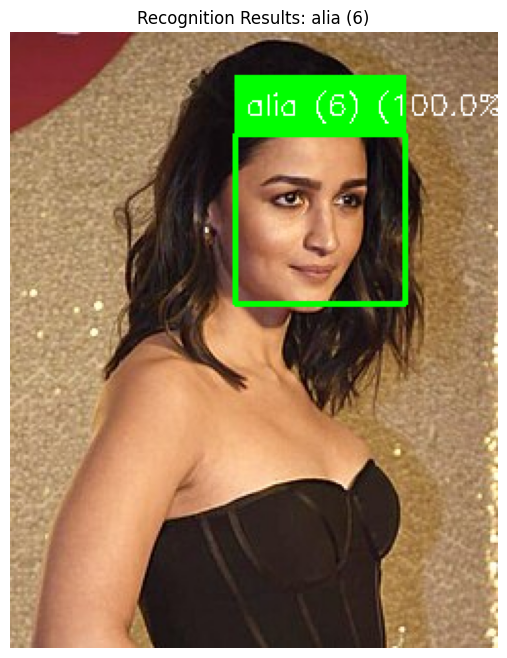

In [25]:
#FACE DETECTION AND RECOGNITION SYSTEM

# Install packages
!pip install opencv-python-headless
!pip install pillow
!pip install scikit-learn
!pip install numpy

# Import libraries
import cv2
import numpy as np
from PIL import Image
import io
from google.colab import files
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
import os

class SimpleFaceRecognizer:
    def __init__(self):
        self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        self.recognizer = cv2.face.LBPHFaceRecognizer_create()
        self.label_encoder = LabelEncoder()
        self.trained = False
        self.names = []

    def extract_faces(self, image):
        """Extract faces from image"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(gray, 1.3, 5)

        face_images = []
        for (x, y, w, h) in faces:
            face = gray[y:y+h, x:x+w]
            face = cv2.resize(face, (200, 200))  # Standardize size
            face_images.append(face)

        return face_images, faces

    def train_from_uploads(self):
        """Train the recogniser from uploaded images"""
        print("Upload training images")
        print("Name files like: person1_john.jpg, person2_mary.jpg, etc.")
        print("You can upload multiple images per person")

        uploaded = files.upload()

        faces = []
        labels = []

        for filename in uploaded.keys():
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                print(f"Processing {filename}...")

                # Extract name from filename
                try:
                    name = filename.split('_')[1].split('.')[0]  # person1_john.jpg -> john
                except:
                    name = filename.split('.')[0]  # fallback to full filename

                # Read image
                image_data = uploaded[filename]
                nparr = np.frombuffer(image_data, np.uint8)
                image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

                # Extract faces
                face_images, face_locations = self.extract_faces(image)

                if face_images:
                    for face_img in face_images:
                        faces.append(face_img)
                        labels.append(name)
                    print(f" Added {len(face_images)} face(s) for {name}")
                else:
                    print(f" No faces found in {filename}")

        if faces:
            # Train the recognizer
            self.names = list(set(labels))
            labels_encoded = self.label_encoder.fit_transform(labels)

            # Train LBPH recognizer
            self.recognizer.train(faces, np.array(labels_encoded))
            self.trained = True

            print(f"\n Training completed!")
            print(f" Learned {len(self.names)} people: {', '.join(self.names)}")
        else:
            print(" No faces found for training!")

    def recognize_faces(self, image):
        """Recognize faces in an image"""
        if not self.trained:
            print(" Model not trained yet!")
            return image, []

        # Extract faces
        face_images, face_locations = self.extract_faces(image)

        results = []
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        for i, (face_img, (x, y, w, h)) in enumerate(zip(face_images, face_locations)):
            # Predict
            label, confidence = self.recognizer.predict(face_img)

            # Get name
            if confidence < 100:  # Lower is better for LBPH
                name = self.label_encoder.inverse_transform([label])[0]
                conf_text = f"{name} ({100-confidence:.1f}%)"
                color = (0, 255, 0)  # Green for recognized
            else:
                name = "Unknown"
                conf_text = "Unknown"
                color = (255, 0, 0)  # Red for unknown

            results.append(name)

            # Draw rectangle and label
            cv2.rectangle(image_rgb, (x, y), (x+w, y+h), color, 2)
            cv2.rectangle(image_rgb, (x, y-30), (x+w, y), color, -1)
            cv2.putText(image_rgb, conf_text, (x+5, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

        return image_rgb, results

# Create recognizer instance
recognizer = SimpleFaceRecognizer()

def train_model():
    """Train the face recognition model"""
    print(" Training Face Recognition Model")
    print("=" * 40)
    recognizer.train_from_uploads()

def test_recognition():
    """Test face recognition"""
    if not recognizer.trained:
        print("Please train the model first!")
        return

    print("🔍 Test Face Recognition")
    print("Upload a test image:")

    uploaded = files.upload()

    for filename in uploaded.keys():
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            print(f"Processing {filename}...")

            # Read image
            image_data = uploaded[filename]
            nparr = np.frombuffer(image_data, np.uint8)
            image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

            # Recognize faces
            result_image, names = recognizer.recognize_faces(image)

            # Display results
            print(f"🎯 Found {len(names)} face(s):")
            for i, name in enumerate(names, 1):
                print(f"  {i}. {name}")

            # Show image
            plt.figure(figsize=(12, 8))
            plt.imshow(result_image)
            plt.title(f'Recognition Results: {", ".join(names) if names else "No faces found"}')
            plt.axis('off')
            plt.show()

def webcam_recognition():
    """Capture photo and recognize"""
    if not recognizer.trained:
        print(" Please train the model first!")
        return

    from IPython.display import display, Javascript
    from google.colab.output import eval_js
    from base64 import b64decode

    def take_photo():
        js = Javascript('''
        async function takePhoto() {
          const div = document.createElement('div');
          const capture = document.createElement('button');
          capture.textContent = 'Take Photo';
          capture.style.background = '#4CAF50';
          capture.style.color = 'white';
          capture.style.padding = '10px 20px';
          capture.style.border = 'none';
          capture.style.borderRadius = '5px';
          div.appendChild(capture);

          const video = document.createElement('video');
          video.style.display = 'block';
          video.style.maxWidth = '100%';
          const stream = await navigator.mediaDevices.getUserMedia({video: true});

          document.body.appendChild(div);
          div.appendChild(video);
          video.srcObject = stream;
          await video.play();

          google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

          await new Promise((resolve) => capture.onclick = resolve);

          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);
          stream.getVideoTracks()[0].stop();
          div.remove();
          return canvas.toDataURL('image/jpeg', 0.8);
        }
        ''')
        display(js)
        data = eval_js('takePhoto()')
        binary = b64decode(data.split(',')[1])

        with open('webcam_photo.jpg', 'wb') as f:
            f.write(binary)
        return 'webcam_photo.jpg'

    print(" Webcam Face Recognition")
    print("Click 'Take Photo' when ready...")

    # Take photo
    photo_file = take_photo()

    # Load and recognize
    image = cv2.imread(photo_file)
    result_image, names = recognizer.recognize_faces(image)

    print(f" Recognition Results:")
    if names:
        for i, name in enumerate(names, 1):
            print(f"  {i}. {name}")
    else:
        print("  No faces detected")

    # Display
    plt.figure(figsize=(12, 8))
    plt.imshow(result_image)
    plt.title(f'Webcam Recognition: {", ".join(names) if names else "No faces"}')
    plt.axis('off')
    plt.show()

    # Cleanup
    os.remove(photo_file)

def main_menu():
    print("Simple Face Recognition System")
    print("=" * 40)
    print("\nChoose an option:")
    print("1. Train model (upload training images)")
    print("2. Test recognition (upload test image)")
    print("3. Webcam recognition")
    print("4. Show trained people")

    choice = input("\nEnter choice (1-4): ")

    if choice == "1":
        train_model()
    elif choice == "2":
        test_recognition()
    elif choice == "3":
        webcam_recognition()
    elif choice == "4":
        if recognizer.trained:
            print(f"👥 Trained people ({len(recognizer.names)}):")
            for i, name in enumerate(recognizer.names, 1):
                print(f"  {i}. {name}")
        else:
            print(" No people trained yet")
    else:
        print("Invalid choice!")

# Run the system
main_menu()

# Quick test function
def quick_test():
    """Quick test with sample images"""
    print("\n Quick Test Mode")
    print("1. Upload 2-3 images of different people for training")
    print("2. Then upload a test image with those people")

    # Train
    print("\n Step 1: Training")
    recognizer.train_from_uploads()

    if recognizer.trained:
        print("\n🔍 Step 2: Testing")
        test_recognition()

quick_test()